In [ ]:
# mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
!pip install pyspark==3.2.0

from pyspark.sql import SparkSession
from pyspark.sql.functions import max, count, desc, rank, sum
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql.functions import row_number


spark = SparkSession.builder.appName("NetflixRankings").getOrCreate()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
#----------------------EXERCISE 1 ----------------------------------
# Load the all_weeks_countries.csv file as a DataFrame using the spark.read.csv() method
df = spark.read.csv("/content/drive/My Drive/Colab Notebooks/8/all_weeks_countries.csv", header=True, inferSchema=True)

# create separate dataframes for films and TV
films_df = df.filter(df.category == "Films")
tv_df = df.filter(df.category == "TV")

# display the number of rows in each dataframe
print("Number of rows in Films dataframe: ", films_df.count())
print("Number of rows in TV dataframe: ", tv_df.count())

# drop season_title column from films_df
films_df = films_df.drop("season_title")

# replace null values in season_title column with show_title
tv_df = tv_df.withColumn("season_title", \
                when(tv_df["season_title"].isNull(), tv_df["show_title"]) \
                .otherwise(tv_df["season_title"]))


# rename cumulative_weeks_in_top_10 column to cumulative_weeks
df = df.withColumnRenamed("cumulative_weeks_in_top_10", "cumulative_weeks")

Number of rows in Films dataframe:  56150
Number of rows in TV dataframe:  56150


+------------+--------------------+------------+---------------+
|country_name|          show_title|highest_rank|weeks_in_top_10|
+------------+--------------------+------------+---------------+
|   Australia|           Bloodshot|           2|              3|
|   Australia|             Traffik|           9|              1|
|   Australia|   Godzilla vs. Kong|           3|              3|
|     Austria|            For Life|           9|             38|
|     Austria|Demon Slayer: Kim...|           8|              6|
|     Bahamas|        Virgin River|          10|             27|
|     Bahamas|   The Longest Night|           4|              3|
|     Bahamas|          The Healer|           6|              1|
|     Bahamas|     The Hurt Locker|           8|              1|
|     Bahrain|          Spiderhead|           3|              3|
|     Bahrain|     Against The Ice|          10|              6|
|     Bahrain|       The Privilege|           7|              1|
|     Bahrain|       L.A.

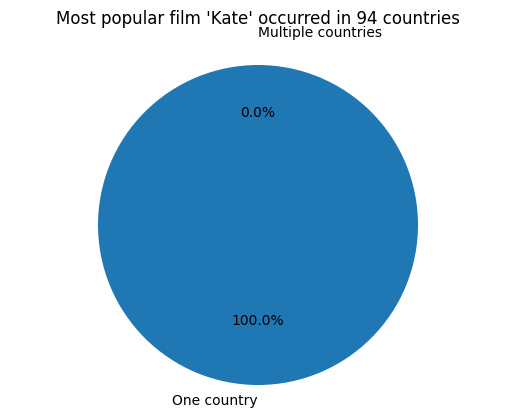

In [26]:
#----------------------EXERCISE 2 ----------------------------------

# group by country_name and show_title
grouped_df = df.groupBy("country_name", "show_title")

# aggregate the highest rank and number of weeks
result_df = grouped_df.agg(max("weekly_rank").alias("highest_rank"), \
                            sum("cumulative_weeks").alias("weeks_in_top_10"))

# display the result dataframe
result_df.show()

# group by country_name and show_title
grouped_df = df.groupBy("country_name", "show_title")

# aggregate the sum of cumulative weeks
result_df = grouped_df.agg(sum("cumulative_weeks").alias("total_weeks"))

# sort by total_weeks in descending order
sorted_df = result_df.sort(desc("total_weeks"))

# get the row with the maximum total_weeks for each country
max_weeks_df = sorted_df.groupBy("country_name").agg(first("show_title").alias("film"), \
                                                     first("total_weeks").alias("weeks"))
# display the result dataframe
max_weeks_df.show()

# group by show_title and count the number of unique countries
grouped_df = df.groupBy("show_title").agg(countDistinct("country_name").alias("num_countries"))

# sort by num_countries in descending order
sorted_df = grouped_df.sort(desc("num_countries"))

# get the most popular film and the corresponding number of countries
most_popular = sorted_df.first()

# plot a pie chart showing the number of countries the most popular film occurred in
labels = ["One country", "Multiple countries"]
sizes = [most_popular["num_countries"], df.select("country_name").distinct().count() - most_popular["num_countries"]]
explode = (0, 0.1)

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')
ax.set_title(f"Most popular film '{most_popular['show_title']}' occurred in {most_popular['num_countries']} countries")

plt.show()



In [ ]:
#----------------------EXERCISE 3 ----------------------------------

# To calculate the number of weeks each TV show spent in each country's top 10, across all seasons

tv_rank_df = tv_df.dropDuplicates(["Title", "Week", "Country"]) \
                  .groupBy("Country", "Title") \
                  .agg(count("Title").alias("WeeksInTop10"))


# To produce a DataFrame that contains the show which spent the most time in each country's top 10

tv_rank_window = Window.partitionBy("Country").orderBy(desc("WeeksInTop10"), "Title")

most_popular_shows_df = tv_rank_df.withColumn("Rank", rank().over(tv_rank_window)) \
                                  .filter("Rank == 1") \
                                  .drop("Rank")
